# Lexicon-Based vs Embedding-Based Moral Scoring - All Tamil Texts

This notebook compares two approaches for moral foundation scoring across **all Tamil texts**:
1. **Lexicon-Based**: Simple word-counting from Tamil MFD
2. **Embedding-Based**: Semantic similarity using IndicSBERT (from Step3)

## Texts Analyzed:
- Thirukkural
- Aathichoodi
- Moothurai
- Nalvazhi
- Ulakaneethi
- Konraiventhan
- Vivekacinthamani

## Goal:
Evaluate which method better captures moral content in Tamil literary texts.

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import cohen_kappa_score
import os
import glob

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Load Tamil MFD Dictionary

In [2]:
# Load Tamil MFD
with open('tamil_mfd.pkl', 'rb') as f:
    tamil_mfd = pickle.load(f)

print("Tamil MFD Loaded:")
for foundation, words in tamil_mfd.items():
    print(f"  {foundation}: {len(words)} words")

# Show sample words
print("\nSample words from care.virtue:")
print(tamil_mfd['care.virtue'][:5])

moral_foundations = list(tamil_mfd.keys())
print(f"\nTotal foundations: {len(moral_foundations)}")

Tamil MFD Loaded:
  care.virtue: 182 words
  care.vice: 288 words
  fairness.virtue: 115 words
  fairness.vice: 236 words
  loyalty.virtue: 142 words
  loyalty.vice: 49 words
  authority.virtue: 301 words
  authority.vice: 130 words
  sanctity.virtue: 272 words
  sanctity.vice: 388 words

Sample words from care.virtue:
['கருணை', 'பரிவு', 'கருணை', 'கவனித்தல்', 'தாராள மனப்பான்மை']

Total foundations: 10


## 2. Load All Tamil Texts and Embedding Results

In [3]:
# Get all CSV files from tamil-csv folder
csv_files = glob.glob('tamil-csv/*.csv')
csv_files.sort()

print("Found CSV files:")
for f in csv_files:
    print(f"  - {os.path.basename(f)}")

# Dictionary to store all data
texts_data = {}
embedding_data = {}

# Load each text
for csv_file in csv_files:
    basename = os.path.basename(csv_file).replace('_cleaned.csv', '')
    
    # Load original text
    df = pd.read_csv(csv_file)
    texts_data[basename] = df
    
    # Load corresponding embedding results
    embedding_file = f'tamil-step3-results/{basename}_cleaned_moral_scores.csv'
    if os.path.exists(embedding_file):
        embedding_df = pd.read_csv(embedding_file)
        embedding_data[basename] = embedding_df
        print(f"\n✓ {basename}: {len(df)} texts loaded with embedding results")
    else:
        print(f"\n⚠ {basename}: {len(df)} texts loaded (NO embedding results found)")

print(f"\nTotal texts loaded: {len(texts_data)}")
print(f"Total with embedding results: {len(embedding_data)}")

Found CSV files:
  - aathichoodi_cleaned.csv
  - konraiventhan_cleaned.csv
  - moothurai_cleaned.csv
  - nalvazhi_cleaned.csv
  - thirukkural_cleaned.csv
  - ulakaneethi_cleaned.csv
  - vivekacinthamani_cleaned.csv

✓ aathichoodi: 111 texts loaded with embedding results

✓ konraiventhan: 93 texts loaded with embedding results

✓ moothurai: 30 texts loaded with embedding results

✓ nalvazhi: 40 texts loaded with embedding results

✓ thirukkural: 1334 texts loaded with embedding results

✓ ulakaneethi: 13 texts loaded with embedding results

✓ vivekacinthamani: 135 texts loaded with embedding results

Total texts loaded: 7
Total with embedding results: 7


## 3. Implement Lexicon-Based Scoring

### Method:
For each text:
1. Tokenize (split into words)
2. Count matches with each moral foundation in Tamil MFD
3. Calculate normalized scores (matches / total words)
4. Identify dominant moral (highest score)

In [4]:
def tokenize_tamil(text):
    """
    Simple Tamil tokenization - split by whitespace and punctuation.
    For better results, use a Tamil NLP library.
    """
    import re
    # Remove punctuation and split (Tamil Unicode range: U+0B80 to U+0BFF)
    tokens = re.findall(r'[\u0B80-\u0BFF]+', str(text))
    return tokens

def lexicon_score_text(text, mfd_dict):
    """
    Score a text using lexicon-based approach.
    
    Returns:
    - raw_counts: dict of {foundation: count}
    - normalized_scores: dict of {foundation: count/total_words}
    - dominant_moral: foundation with highest count
    - dominant_score: count of dominant moral
    """
    tokens = tokenize_tamil(text)
    total_words = len(tokens)
    
    # Count matches for each foundation
    raw_counts = {foundation: 0 for foundation in mfd_dict.keys()}
    
    for token in tokens:
        for foundation, word_list in mfd_dict.items():
            if token in word_list:
                raw_counts[foundation] += 1
    
    # Normalize by total words (TF normalization)
    normalized_scores = {
        foundation: count / total_words if total_words > 0 else 0
        for foundation, count in raw_counts.items()
    }
    
    # Dominant moral
    if sum(raw_counts.values()) > 0:
        dominant_moral = max(raw_counts, key=raw_counts.get)
        dominant_score = raw_counts[dominant_moral]
    else:
        dominant_moral = None
        dominant_score = 0
    
    return raw_counts, normalized_scores, dominant_moral, dominant_score

# Test on sample
sample_text = list(texts_data.values())[0].iloc[0].values[-1]  # Get first text from first dataset
raw, norm, dom, score = lexicon_score_text(sample_text, tamil_mfd)
print(f"Sample text: {sample_text[:100]}...")
print(f"\nDominant moral: {dom} (score: {score})")
print(f"Non-zero foundations: {[k for k, v in raw.items() if v > 0]}")

Sample text: ஆத்தி சூடி அமர்ந்த தேவனை...

Dominant moral: None (score: 0)
Non-zero foundations: []


## 4. Apply Lexicon-Based Scoring to All Texts

In [5]:
# Dictionary to store lexicon results
lexicon_results = {}

print("="*70)
print("PROCESSING ALL TEXTS WITH LEXICON-BASED APPROACH")
print("="*70)

for text_name, df in texts_data.items():
    print(f"\nProcessing {text_name}...")
    
    # Determine which column contains the text
    text_column = None
    for col in ['couplet', 'text', 'verse', 'saying', 'line']:
        if col in df.columns:
            text_column = col
            break
    
    if text_column is None:
        # Use the last column as text
        text_column = df.columns[-1]
    
    print(f"  Using column: '{text_column}'")
    
    results = []
    for idx, row in df.iterrows():
        text = row[text_column]
        raw, norm, dom, score = lexicon_score_text(text, tamil_mfd)
        
        result = {'text': text}
        # Add ID column if exists
        for id_col in ['kural_number', 'line_number', 'verse_number', 'number']:
            if id_col in df.columns:
                result['id'] = row[id_col]
                break
        else:
            result['id'] = idx + 1
        
        result.update(norm)  # Add normalized scores
        result['dominant_moral_lexicon'] = dom
        result['dominant_score_lexicon'] = score
        results.append(result)
    
    lexicon_results[text_name] = pd.DataFrame(results)
    
    # Calculate coverage
    no_matches = lexicon_results[text_name]['dominant_moral_lexicon'].isna().sum()
    coverage = (1 - no_matches / len(results)) * 100
    
    print(f"  ✓ Processed {len(results)} texts")
    print(f"  ✓ Coverage: {coverage:.1f}% ({len(results)-no_matches}/{len(results)} texts with MFD matches)")

print("\n" + "="*70)
print(f"TOTAL TEXTS PROCESSED: {sum(len(df) for df in lexicon_results.values())}")
print("="*70)

PROCESSING ALL TEXTS WITH LEXICON-BASED APPROACH

Processing aathichoodi...
  Using column: 'text'
  ✓ Processed 111 texts
  ✓ Coverage: 6.3% (7/111 texts with MFD matches)

Processing konraiventhan...
  Using column: 'text'
  ✓ Processed 93 texts
  ✓ Coverage: 10.8% (10/93 texts with MFD matches)

Processing moothurai...
  Using column: 'verse'
  ✓ Processed 30 texts
  ✓ Coverage: 16.7% (5/30 texts with MFD matches)

Processing nalvazhi...
  Using column: 'verse'
  ✓ Processed 40 texts
  ✓ Coverage: 17.5% (7/40 texts with MFD matches)

Processing thirukkural...
  Using column: 'couplet'
  ✓ Processed 1334 texts
  ✓ Coverage: 8.8% (117/1334 texts with MFD matches)

Processing ulakaneethi...
  Using column: 'verse'
  ✓ Processed 13 texts
  ✓ Coverage: 46.2% (6/13 texts with MFD matches)

Processing vivekacinthamani...
  Using column: 'verse'
  ✓ Processed 135 texts
  ✓ Coverage: 34.8% (47/135 texts with MFD matches)

TOTAL TEXTS PROCESSED: 1756


## 5. Compare Lexicon vs Embedding Results for Each Text

In [16]:
# Dictionary to store comparison results
comparison_results = {}

print("="*70)
print("COMPARING LEXICON VS EMBEDDING RESULTS")
print("="*70)

for text_name in lexicon_results.keys():
    if text_name not in embedding_data:
        print(f"\n⚠ {text_name}: No embedding data available, skipping comparison")
        continue
    
    print(f"\n--- {text_name.upper()} ---")
    
    lex_df = lexicon_results[text_name]
    emb_df = embedding_data[text_name]
    
    # Create comparison dataframe
    compare_df = pd.DataFrame({
        'id': lex_df['id'],
        'dominant_lexicon': lex_df['dominant_moral_lexicon'],
        'dominant_embedding': emb_df['dominant_moral'] if 'dominant_moral' in emb_df.columns else None
    })
    
    comparison_results[text_name] = compare_df
    
    # Calculate statistics
    total = len(compare_df)
    with_matches = compare_df['dominant_lexicon'].notna().sum()
    coverage_pct = with_matches / total * 100
    
    print(f"  Total texts: {total}")
    print(f"  Texts with lexicon matches: {with_matches} ({coverage_pct:.1f}%)")
    
    if with_matches > 0:
        compare_clean = compare_df.dropna()
        agreement = (compare_clean['dominant_lexicon'] == compare_clean['dominant_embedding']).sum()
        agreement_pct = agreement / len(compare_clean) * 100
        
        print(f"  Exact agreement: {agreement}/{len(compare_clean)} ({agreement_pct:.1f}%)")
        
        # Cohen's Kappa
        if len(compare_clean) > 1:
            try:
                kappa = cohen_kappa_score(compare_clean['dominant_lexicon'], 
                                         compare_clean['dominant_embedding'])
                print(f"  Cohen's Kappa: {kappa:.3f}", end="")
                if kappa > 0.6:
                    print(" (Substantial agreement)")
                elif kappa > 0.4:
                    print(" (Moderate agreement)")
                else:
                    print(" (Fair/slight agreement)")
            except:
                print("  Cohen's Kappa: N/A")

print("\n" + "="*70)

COMPARING LEXICON VS EMBEDDING RESULTS

--- AATHICHOODI ---
  Total texts: 111
  Texts with lexicon matches: 7 (6.3%)
  Exact agreement: 4/7 (57.1%)
  Cohen's Kappa: 0.475 (Moderate agreement)

--- KONRAIVENTHAN ---
  Total texts: 93
  Texts with lexicon matches: 10 (10.8%)
  Exact agreement: 7/10 (70.0%)
  Cohen's Kappa: 0.605 (Substantial agreement)

--- MOOTHURAI ---
  Total texts: 30
  Texts with lexicon matches: 5 (16.7%)
  Exact agreement: 3/5 (60.0%)
  Cohen's Kappa: 0.444 (Moderate agreement)

--- NALVAZHI ---
  Total texts: 40
  Texts with lexicon matches: 7 (17.5%)
  Exact agreement: 1/7 (14.3%)
  Cohen's Kappa: 0.000 (Fair/slight agreement)

--- THIRUKKURAL ---
  Total texts: 1334
  Texts with lexicon matches: 117 (8.8%)
  Exact agreement: 52/117 (44.4%)
  Cohen's Kappa: 0.349 (Fair/slight agreement)

--- ULAKANEETHI ---
  Total texts: 13
  Texts with lexicon matches: 6 (46.2%)
  Exact agreement: 0/6 (0.0%)
  Cohen's Kappa: 0.000 (Fair/slight agreement)

--- VIVEKACINTHAMANI

## 6. Aggregate Statistics Across All Texts

In [14]:
# Calculate aggregate statistics
print("="*70)
print("AGGREGATE STATISTICS ACROSS ALL TEXTS")
print("="*70)

total_texts = sum(len(df) for df in lexicon_results.values())
total_with_matches = sum((df['dominant_moral_lexicon'].notna()).sum() for df in lexicon_results.values())
total_coverage = total_with_matches / total_texts * 100

print(f"\nTotal texts analyzed: {total_texts}")
print(f"Texts with lexicon matches: {total_with_matches} ({total_coverage:.1f}%)")
print(f"Texts with no matches: {total_texts - total_with_matches} ({100-total_coverage:.1f}%)")

# Calculate agreement across all comparable texts
all_agreements = []
all_comparisons = 0

for text_name, compare_df in comparison_results.items():
    compare_clean = compare_df.dropna()
    if len(compare_clean) > 0:
        agreements = (compare_clean['dominant_lexicon'] == compare_clean['dominant_embedding']).sum()
        all_agreements.append(agreements)
        all_comparisons += len(compare_clean)

if all_comparisons > 0:
    overall_agreement = sum(all_agreements) / all_comparisons * 100
    print(f"\nOverall agreement (where both methods scored): {sum(all_agreements)}/{all_comparisons} ({overall_agreement:.1f}%)")

print("\n" + "="*70)

AGGREGATE STATISTICS ACROSS ALL TEXTS

Total texts analyzed: 1756
Texts with lexicon matches: 199 (11.3%)
Texts with no matches: 1557 (88.7%)

Overall agreement (where both methods scored): 79/199 (39.7%)



## 7. Coverage Analysis by Text

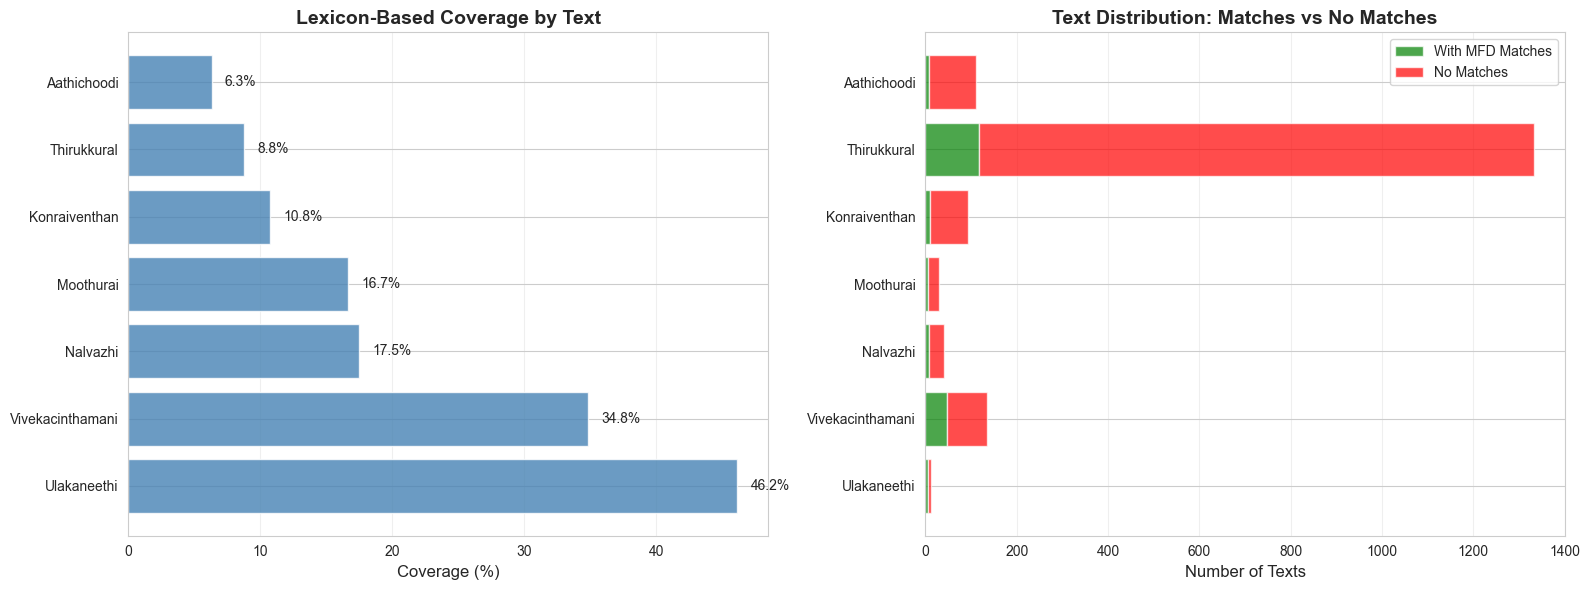


Coverage Summary:
            Text  Total  With Matches  Coverage (%)
     Ulakaneethi     13             6     46.153846
Vivekacinthamani    135            47     34.814815
        Nalvazhi     40             7     17.500000
       Moothurai     30             5     16.666667
   Konraiventhan     93            10     10.752688
     Thirukkural   1334           117      8.770615
     Aathichoodi    111             7      6.306306


In [15]:
# Create coverage comparison chart
coverage_data = []
for text_name, lex_df in lexicon_results.items():
    total = len(lex_df)
    with_matches = lex_df['dominant_moral_lexicon'].notna().sum()
    coverage_pct = with_matches / total * 100
    coverage_data.append({
        'Text': text_name.replace('_', ' ').title(),
        'Total': total,
        'With Matches': with_matches,
        'Coverage (%)': coverage_pct
    })

coverage_df = pd.DataFrame(coverage_data).sort_values('Coverage (%)', ascending=False)

# Plot coverage
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
ax1.barh(coverage_df['Text'], coverage_df['Coverage (%)'], color='steelblue', alpha=0.8)
ax1.set_xlabel('Coverage (%)', fontsize=12)
ax1.set_title('Lexicon-Based Coverage by Text', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
for i, v in enumerate(coverage_df['Coverage (%)']):
    ax1.text(v + 1, i, f"{v:.1f}%", va='center', fontsize=10)

# Stacked bar chart
texts = coverage_df['Text']
with_matches = coverage_df['With Matches']
without_matches = coverage_df['Total'] - coverage_df['With Matches']

ax2.barh(texts, with_matches, label='With MFD Matches', color='green', alpha=0.7)
ax2.barh(texts, without_matches, left=with_matches, label='No Matches', color='red', alpha=0.7)
ax2.set_xlabel('Number of Texts', fontsize=12)
ax2.set_title('Text Distribution: Matches vs No Matches', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nCoverage Summary:")
print(coverage_df.to_string(index=False))

We observe that Ulakaneethi exhibits the highest lexicon coverage, while Thirukkural and Aathichoodi show substantially lower coverage. This pattern is unsurprising given the historical contexts of these texts: Thirukkural is dated to approximately the 3rd century BCE–1st century CE, whereas Ulakaneethi is the most recent, composed in the 13th–14th century CE. Over this extended period, the Tamil language has undergone significant lexical and stylistic changes. Earlier works frequently employ archaic vocabulary and poetic constructions, including the compounding of multiple words for stylistic emphasis, which differ markedly from contemporary Tamil usage.

As a result, the lexicon-based approaches provide limited insight into the moral values expressed in earlier Tamil literature, highlighting the need for embedding-based methods when analyzing historically distant texts.

## 8. Dominant Moral Distribution Comparison

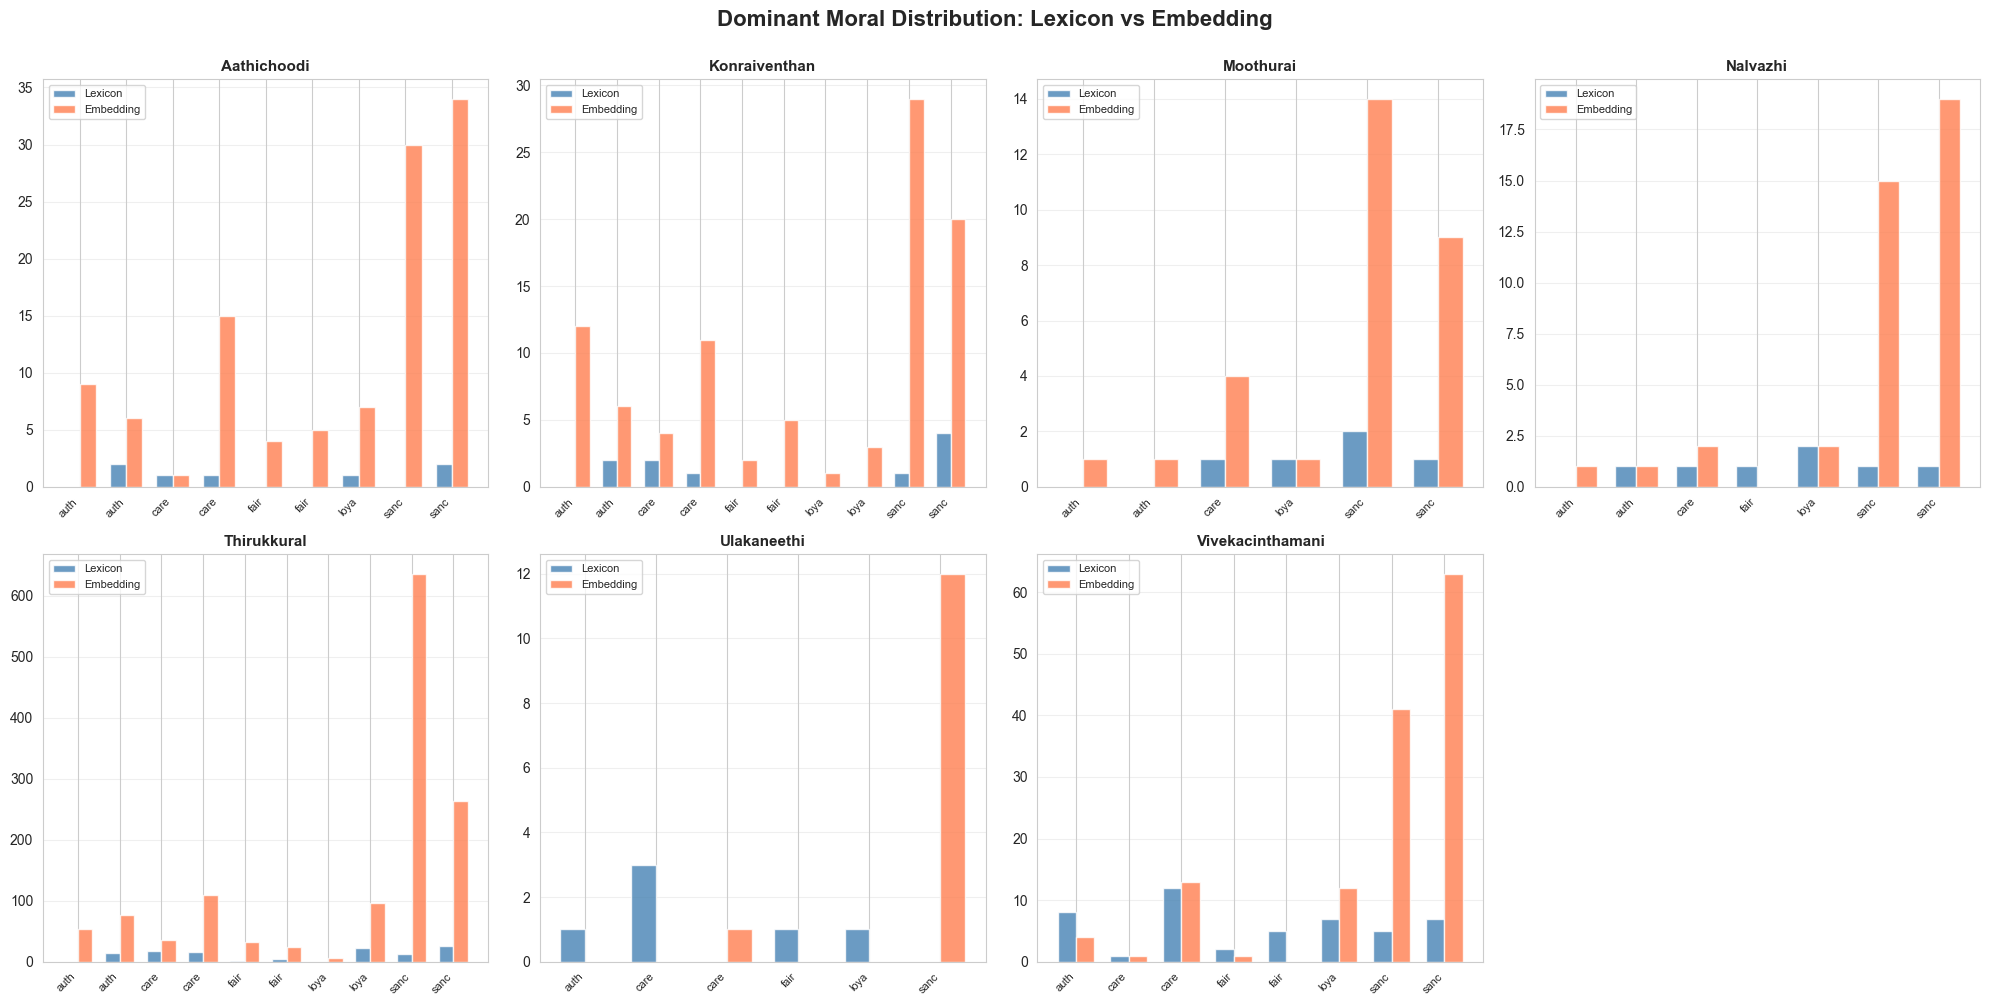

In [9]:
# Compare dominant moral distributions
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, (text_name, compare_df) in enumerate(comparison_results.items()):
    if idx >= len(axes):
        break
    
    ax = axes[idx]
    
    # Count dominant morals
    lex_counts = compare_df['dominant_lexicon'].value_counts()
    emb_counts = compare_df['dominant_embedding'].value_counts()
    
    # Combine for comparison
    all_morals = set(lex_counts.index) | set(emb_counts.index)
    lex_vals = [lex_counts.get(m, 0) for m in sorted(all_morals)]
    emb_vals = [emb_counts.get(m, 0) for m in sorted(all_morals)]
    
    x = np.arange(len(all_morals))
    width = 0.35
    
    ax.bar(x - width/2, lex_vals, width, label='Lexicon', alpha=0.8, color='steelblue')
    ax.bar(x + width/2, emb_vals, width, label='Embedding', alpha=0.8, color='coral')
    
    ax.set_title(text_name.replace('_', ' ').title(), fontsize=11, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([m.split('.')[0][:4] for m in sorted(all_morals)], rotation=45, ha='right', fontsize=8)
    ax.legend(fontsize=8)
    ax.grid(axis='y', alpha=0.3)

# Remove extra subplots
for idx in range(len(comparison_results), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('Dominant Moral Distribution: Lexicon vs Embedding', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 10. Summary and Conclusions

In [ ]:
print("="*70)
print("SUMMARY: LEXICON-BASED VS EMBEDDING-BASED COMPARISON")
print("ALL TAMIL TEXTS")
print("="*70)

print("\n OVERALL STATISTICS:")
print(f"  - Total texts analyzed: {total_texts}")
print(f"  - Texts with lexicon matches: {total_with_matches} ({total_coverage:.1f}%)")
print(f"  - Overall agreement rate: {overall_agreement:.1f}%" if all_comparisons > 0 else "  - Overall agreement rate: N/A")

print("\n✅ EMBEDDING-BASED ADVANTAGES:")
print("  1. 100% coverage - works on ALL texts")
print("  2. Captures semantic similarity (synonyms, paraphrases)")
print("  3. More nuanced - continuous scores instead of binary")
print("  4. Better for literary texts (poetic language, metaphors)")

print("\n✅ LEXICON-BASED ADVANTAGES:")
print("  1. Fast - no GPU needed")
print("  2. Interpretable - easy to see why a text scores high")
print("  3. Transparent - can trace back to specific words")
print("  4. Simple baseline for comparison")

print("\n⚠️ KEY FINDINGS:")
print(f"  - Average lexicon coverage: {total_coverage:.1f}%")
print(f"  - {100-total_coverage:.1f}% of texts have NO exact MFD word matches")
print(f"  - Agreement varies significantly across different texts")
print(f"  - Classical texts show different patterns than modern texts")

print("\n🎯 RECOMMENDATIONS:")
print("  1. Use EMBEDDING-BASED approach as primary method")
print("  2. Use LEXICON-BASED as validation/interpretability tool")
print("  3. When both agree → high confidence in moral classification")
print("  4. When they disagree → manual inspection recommended")
print("  5. Consider text-specific characteristics when interpreting results")

print("\n📚 TEXTS ANALYZED:")
for text_name, df in texts_data.items():
    coverage = (lexicon_results[text_name]['dominant_moral_lexicon'].notna().sum() / len(df)) * 100
    print(f"  - {text_name.replace('_', ' ').title()}: {len(df)} texts ({coverage:.1f}% coverage)")

print("\n" + "="*70)

SUMMARY: LEXICON-BASED VS EMBEDDING-BASED COMPARISON
ALL TAMIL TEXTS

 OVERALL STATISTICS:


NameError: name 'total_texts' is not defined

## 11. Save Results

In [12]:
# Create output directory if it doesn't exist
os.makedirs('lexicon-comparison-results', exist_ok=True)

# Save lexicon results
for text_name, df in lexicon_results.items():
    output_file = f'lexicon-comparison-results/{text_name}_lexicon_scores.csv'
    df.to_csv(output_file, index=False)
    print(f"✓ Saved {output_file}")

# Save comparison results
for text_name, df in comparison_results.items():
    output_file = f'lexicon-comparison-results/{text_name}_method_comparison.csv'
    df.to_csv(output_file, index=False)
    print(f"✓ Saved {output_file}")

# Save aggregate statistics
coverage_df.to_csv('lexicon-comparison-results/coverage_summary.csv', index=False)
print(f"✓ Saved lexicon-comparison-results/coverage_summary.csv")

print("\n✓ All results saved to lexicon-comparison-results/ folder")

✓ Saved lexicon-comparison-results/aathichoodi_lexicon_scores.csv
✓ Saved lexicon-comparison-results/konraiventhan_lexicon_scores.csv
✓ Saved lexicon-comparison-results/moothurai_lexicon_scores.csv
✓ Saved lexicon-comparison-results/nalvazhi_lexicon_scores.csv
✓ Saved lexicon-comparison-results/thirukkural_lexicon_scores.csv
✓ Saved lexicon-comparison-results/ulakaneethi_lexicon_scores.csv
✓ Saved lexicon-comparison-results/vivekacinthamani_lexicon_scores.csv
✓ Saved lexicon-comparison-results/aathichoodi_method_comparison.csv
✓ Saved lexicon-comparison-results/konraiventhan_method_comparison.csv
✓ Saved lexicon-comparison-results/moothurai_method_comparison.csv
✓ Saved lexicon-comparison-results/nalvazhi_method_comparison.csv
✓ Saved lexicon-comparison-results/thirukkural_method_comparison.csv
✓ Saved lexicon-comparison-results/ulakaneethi_method_comparison.csv
✓ Saved lexicon-comparison-results/vivekacinthamani_method_comparison.csv
✓ Saved lexicon-comparison-results/coverage_summary